In [22]:
# Basic packages always been used
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Data scaling
from sklearn.preprocessing import MinMaxScaler

# Function for spilting training & testing data set
from sklearn.model_selection import train_test_split

# Tensorflow sequential models
from tensorflow import keras
from keras import backend as clear
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import GRU
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.optimizers import SGD
from keras.optimizers import Adam
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import TimeSeriesSplit

# Functions for evaluation
from sklearn.metrics import mean_absolute_error #MAE
from sklearn.metrics import mean_squared_error #MSE,RMSE
from sklearn.metrics import mean_absolute_percentage_error #MAPE

In [23]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
# Symmetric Mean Absolute Percentage Error (SMAPE)
def SMAPE_calulate(y_true, y_pred):
    n = len(y_true)
    SMAPE=(100 / n) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true)))
    return SMAPE

# Relative Absolute Error (RAE)
def RAE_calculate(y_true, y_pred):
    abs_errors = np.abs(y_true - y_pred)
    denominator = np.sum(np.abs(y_true - np.mean(y_true)))
    RAE=np.sum(abs_errors/denominator)
    return RAE

# Mean Relative Absolute Error (MRAE)
def MRAE_calculate(y_true, y_pred):
    n=len(y_true)
    abs_errors = np.abs(y_true - y_pred)
    denominator = np.sum(np.abs(y_true - np.mean(y_true)))
    RAE=np.sum(abs_errors/denominator)
    MRAE=RAE/n
    return MRAE

# Median Relative Absolute Error (MdRAE) comparing with benchmark
# Note: By default, the bench value is the mean of actual value
def MdRAE_calculate(y_true, y_pred, bench=None):
    if bench==None:
        bench=np.mean(y_true)
        MdRAE=np.median(np.abs(y_true - y_pred)/np.abs(y_true - bench))
        return MdRAE,bench
    else:
        MdRAE=np.median(np.abs(y_true - y_pred)/np.abs(y_true - bench))
        return MdRAE

# Relative Squared Error (RSE) & Root Relative Squared Error (RRSE)
def RSE_calculate(y_true, y_pred, Root=False):
    mse = np.mean((y_true - y_pred)**2)
    denominator = np.var(y_true)
    RSE=mse/denominator

    if Root==True:
        return np.sqrt(RSE)
    else:
        return RSE

from keras.losses import mse
from keras.backend import sqrt

def my_RMSE(y_true, y_pred):
    return sqrt(mse(y_true, y_pred))

In [25]:
#load data(sometimes need to use "/")
#df = pd.read_csv('D:/pythonData/python_demo_data/Rainfall_Forecast.csv')
# Colab
df = pd.read_csv('/content/drive/MyDrive/StockData/MSFT.csv')
df

,Date,Close
0,2/6/2014,40.790001
1,3/6/2014,40.290001
2,4/6/2014,40.320000
3,5/6/2014,41.209999
4,6/6/2014,41.480000
...,...,...
2260,23/5/2023,315.260010
2261,24/5/2023,313.850006
2262,25/5/2023,325.920013
2263,26/5/2023,332.890015


In [26]:
# Date is converted into special data type of pandas
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2265 entries, 0 to 2264
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    2265 non-null   object 
 1   Close   2265 non-null   float64
dtypes: float64(1), object(1)
memory usage: 35.5+ KB


In [27]:
# View descriptive statistics of target variable
# Pandas will automatically ignore date if the correct data type has been converted
new_df = df
new_df.describe()

,Close
count,2265.000000
mean,142.370631
std,91.763318
min,40.290001
25%,57.419998
50%,108.300003
75%,231.600006
max,343.109985


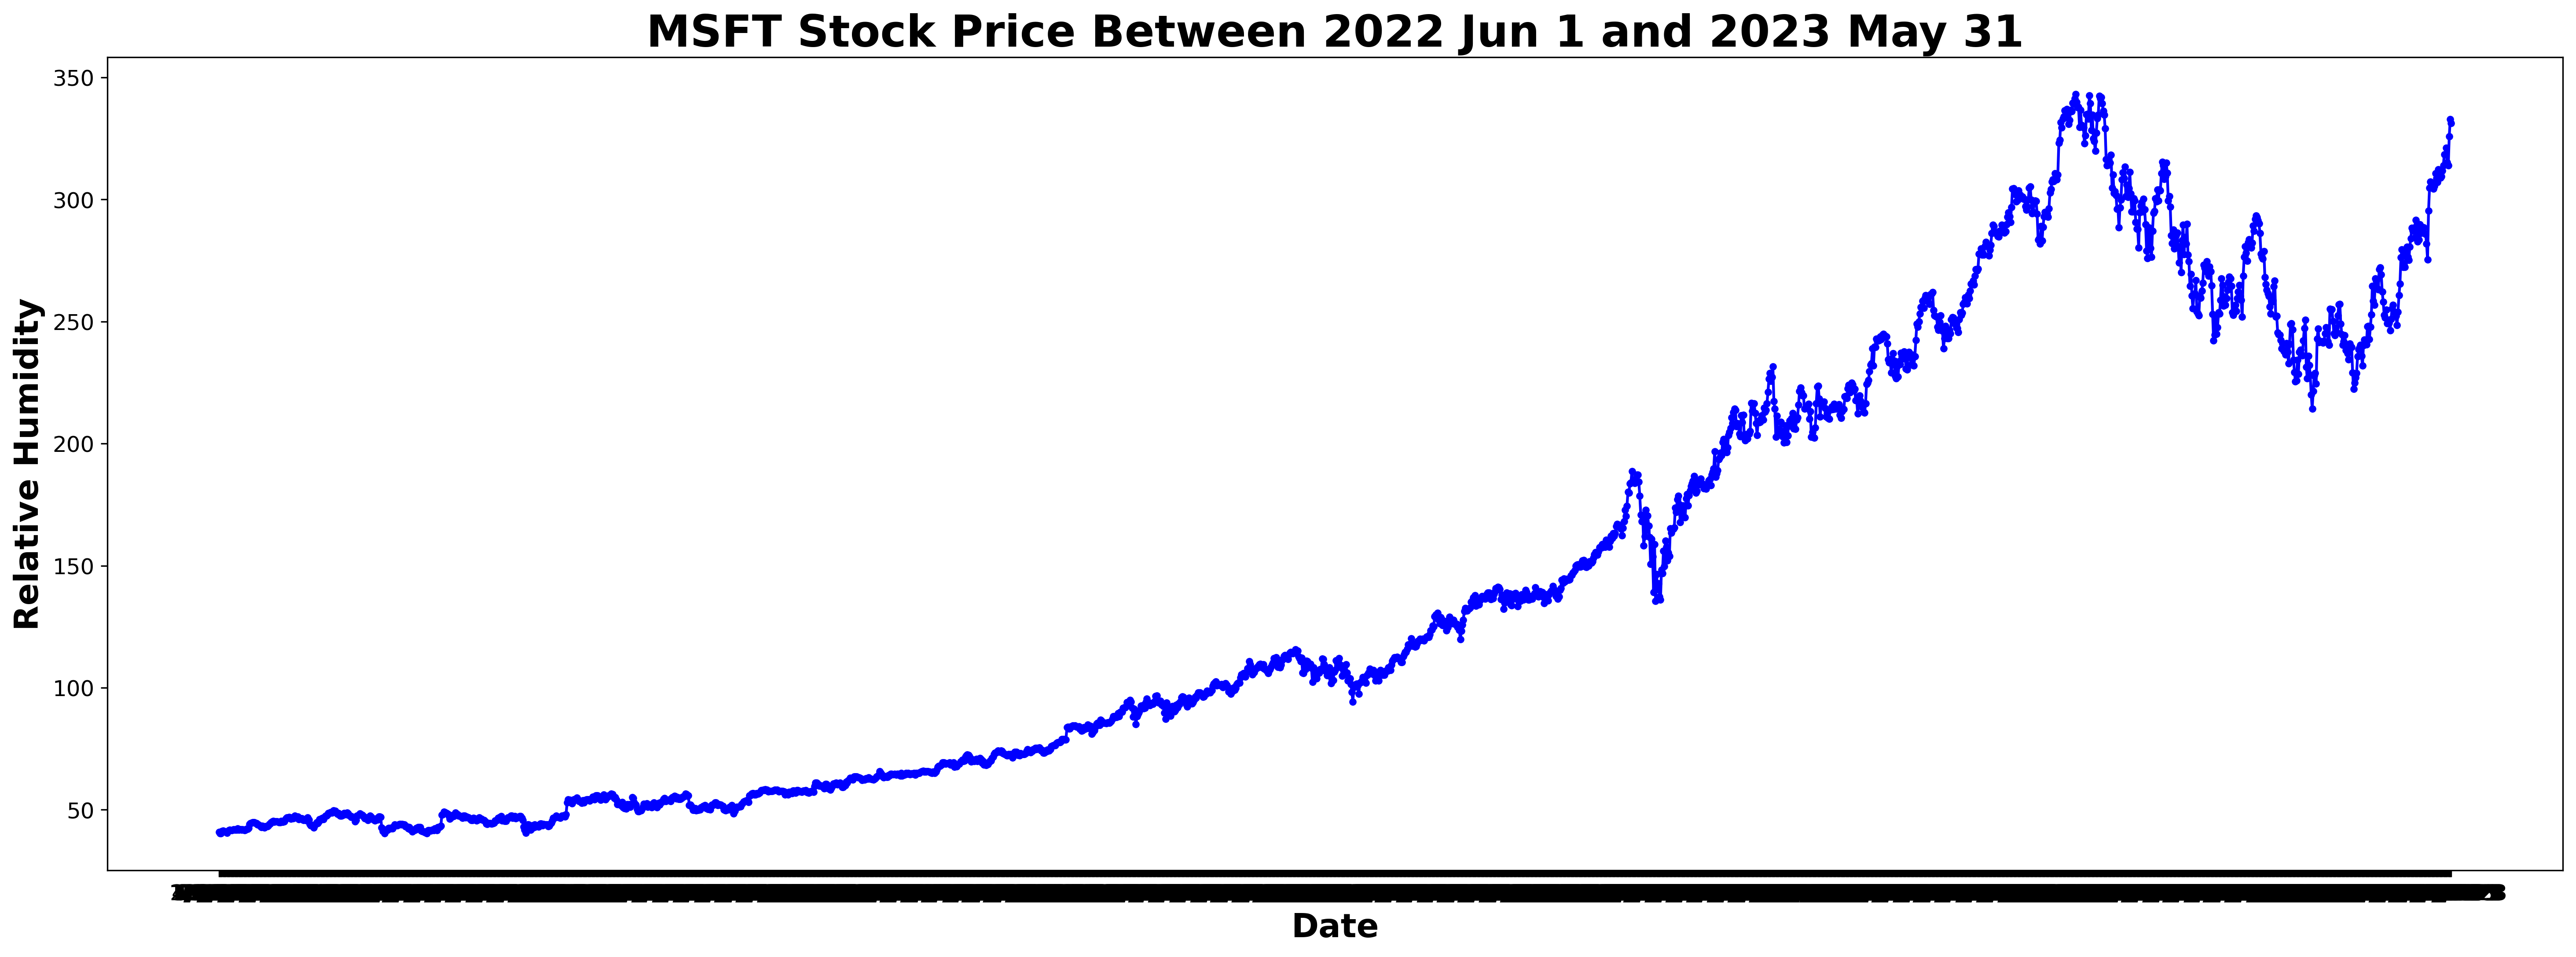

In [28]:
# Plot Y and its corresponding date
# Figure setting
plt.figure(figsize=(24,8),dpi=300)
plt.title('MSFT Stock Price Between 2022 Jun 1 and 2023 May 31',weight='bold',fontsize=24)
plt.xlabel('Date',fontsize=18,weight='bold')
plt.ylabel('Relative Humidity',fontsize=18,weight='bold')

# Actual by predicted plot
plt.plot(new_df['Date'],new_df['Close'],marker='.',color='blue')

# Set the axis
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [29]:
# Create 3 lags
new_df['Lag_1']=new_df['Close'].shift(1).copy()
new_df.head()

,Date,Close,Lag_1
0,2/6/2014,40.790001,NaN
1,3/6/2014,40.290001,40.790001
2,4/6/2014,40.320000,40.290001
3,5/6/2014,41.209999,40.320000
4,6/6/2014,41.480000,41.209999


In [30]:
# Drop out missing values and rest index
clean_df=new_df.dropna(axis=0, how='any').copy()
clean_df=clean_df.reset_index(drop=True)
clean_df

,Date,Close,Lag_1
0,3/6/2014,40.290001,40.790001
1,4/6/2014,40.320000,40.290001
2,5/6/2014,41.209999,40.320000
3,6/6/2014,41.480000,41.209999
4,9/6/2014,41.270000,41.480000
...,...,...,...
2259,23/5/2023,315.260010,321.179993
2260,24/5/2023,313.850006,315.260010
2261,25/5/2023,325.920013,313.850006
2262,26/5/2023,332.890015,325.920013


In [31]:
rseValue = RSE_calculate(clean_df['Close'], clean_df['Lag_1'])
print("RSE:",rseValue)

rmseValue = my_RMSE(clean_df['Close'], clean_df['Lag_1'])
print("RMSE:",rmseValue.numpy())

smapeValue = SMAPE_calulate(clean_df['Close'], clean_df['Lag_1'])
print("SMAPE:",smapeValue)

raeValue = RAE_calculate(clean_df['Close'], clean_df['Lag_1'])
print("RAE:",raeValue)

mraeValue = MRAE_calculate(clean_df['Close'], clean_df['Lag_1'])
print("MRAE:",mraeValue)

mdraeValue = MdRAE_calculate(clean_df['Close'], clean_df['Lag_1'])
print("MDRAE:",mdraeValue)



RSE: 0.0011739400787468366
RMSE: 3.14321767043726
SMAPE: 1.1868972033531542
RAE: 0.02267650105825803
MRAE: 1.0016122375555666e-05
MDRAE: (0.012057181202520485, 142.41549912323322)


In [32]:
# 8.2 Calculating the mertics
MAE=mean_absolute_error(clean_df['Close'], clean_df['Lag_1'])
MSE=mean_squared_error(clean_df['Close'], clean_df['Lag_1'],squared=True)
RMSE=mean_squared_error(clean_df['Close'], clean_df['Lag_1'],squared=False)
MAPE=mean_absolute_percentage_error(clean_df['Close'], clean_df['Lag_1'])
SMAPE=SMAPE_calulate(clean_df['Close'], clean_df['Lag_1'])
RAE=RAE_calculate(clean_df['Close'], clean_df['Lag_1'])
MRAE=MRAE_calculate(clean_df['Close'], clean_df['Lag_1'])
MdRAE=MdRAE_calculate(clean_df['Close'], clean_df['Lag_1'])
RSE=RSE_calculate(clean_df['Close'], clean_df['Lag_1'],Root=False)
RRSE=RSE_calculate(clean_df['Close'], clean_df['Lag_1'],Root=True)

print('MAE:',round(MAE,3))
print('MSE:',round(MSE,3))
print('RMSE:',round(RMSE,3))
print('MAPE:',round(MAPE*100,3),'%')
print('SMAPE:',round(SMAPE,3),'%')
print('RAE:',round(RAE,3))
print('MRAE:',MRAE)
print('MdRAE:',round(MdRAE[0],3),'bench:',round(MdRAE[1],3))
print('RSE:',round(RSE,3))
print('RRSE:',round(RRSE,3))

MAE: 1.842
MSE: 9.88
RMSE: 3.143
MAPE: 1.186 %
SMAPE: 1.187 %
RAE: 0.023
MRAE: 1.0016122375555666e-05
MdRAE: 0.012 bench: 142.415
RSE: 0.001
RRSE: 0.034


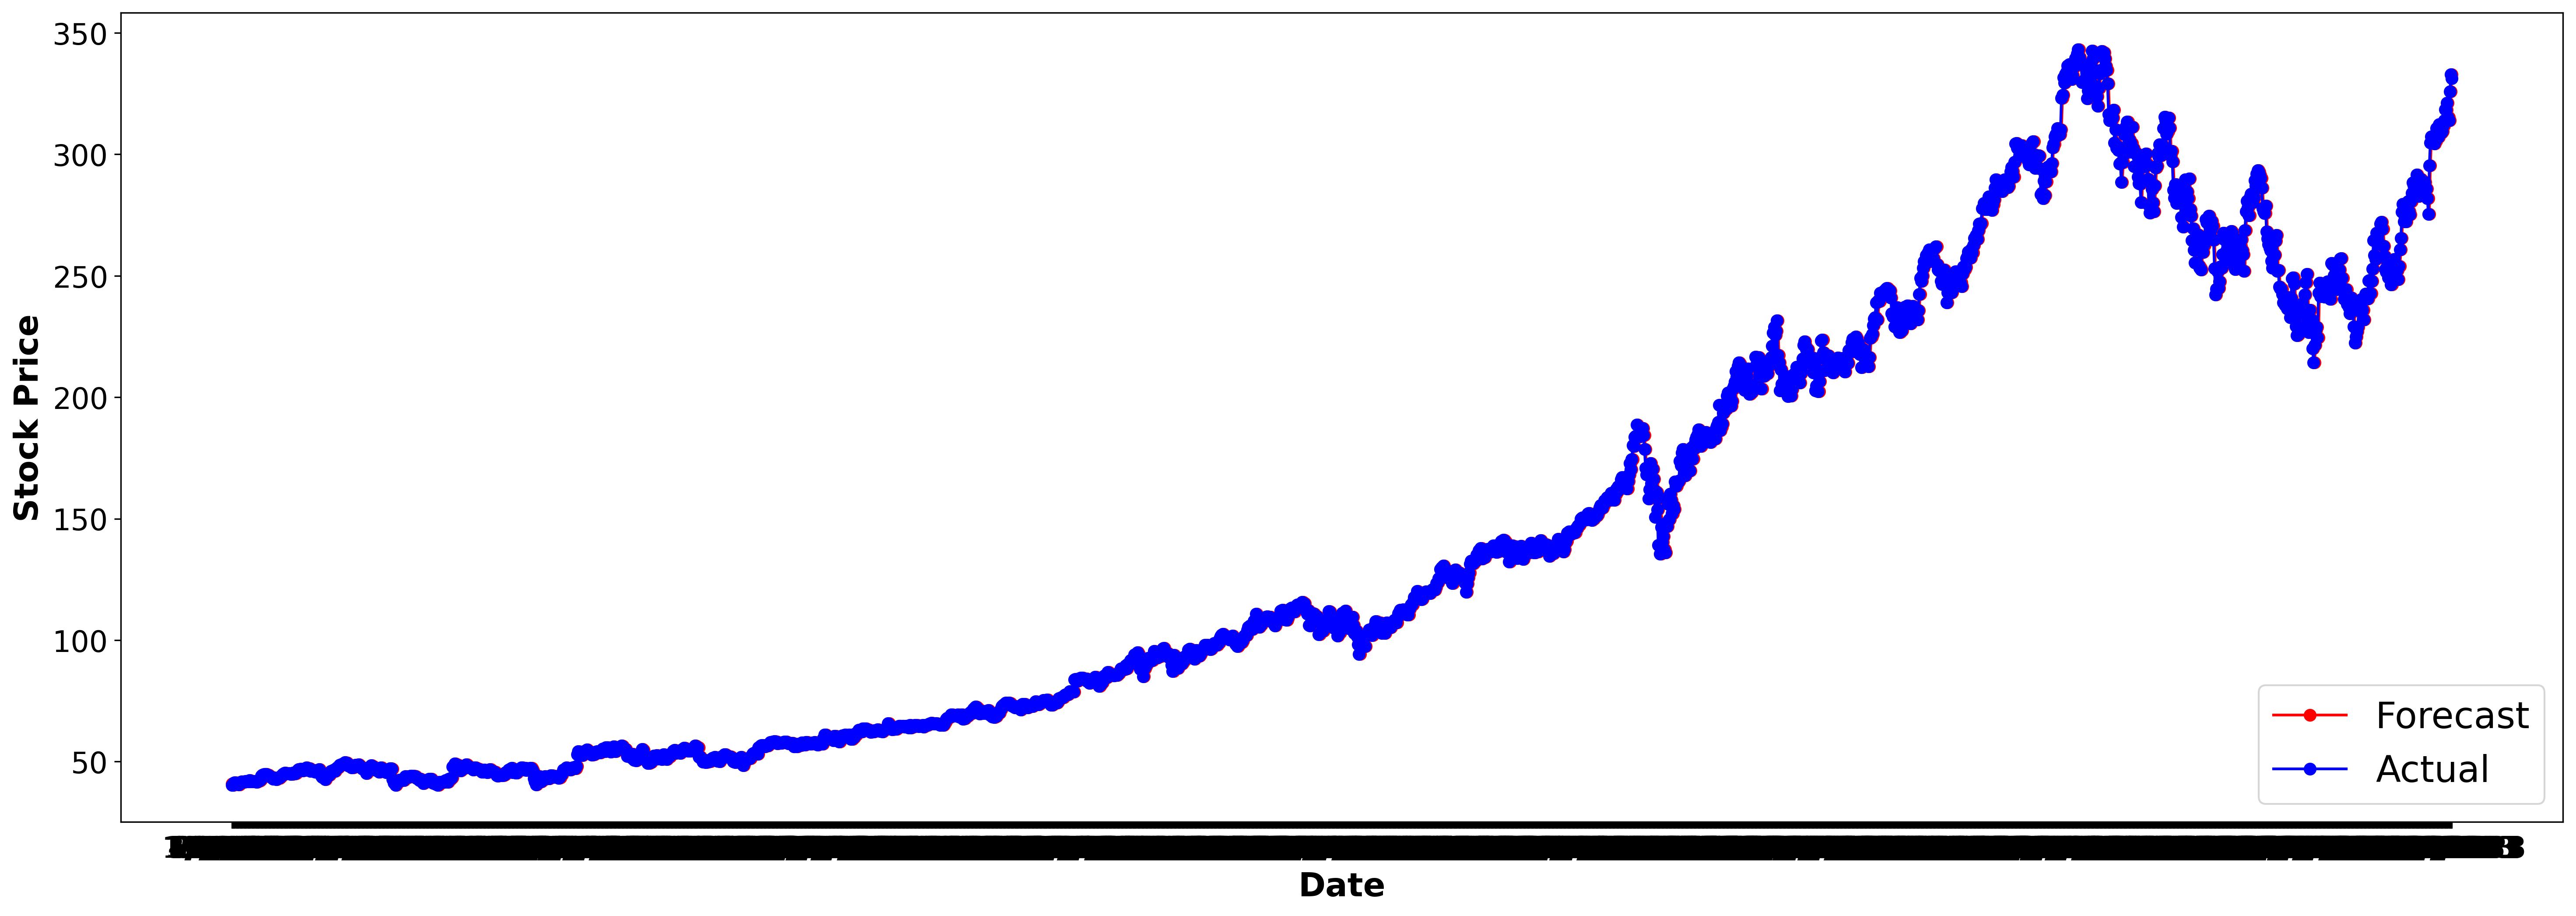

In [33]:
# Plot Y and its corresponding date
# Figure setting
plt.figure(figsize=(24,8),dpi=300)
plt.title('',weight='bold',fontsize=24)
plt.xlabel('Date',fontsize=18,weight='bold')
plt.ylabel('Stock Price',fontsize=18,weight='bold')

# Comparison of actual value and predicted value according to Date
#result = (clean_df['Date'], clean_df['Close'])
#plt.plot(result.iloc[1800:,0],result.iloc[1800:,1],marker='o',color='blue',label='Actual')
plt.plot(clean_df['Date'],clean_df['Lag_1'],marker='o',color='red',label='Forecast')
plt.plot(clean_df['Date'],clean_df['Close'],marker='o',color='blue',label='Actual')

# Set the axis
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# Set legends
plt.legend(loc=4,fontsize=20)

plt.show()

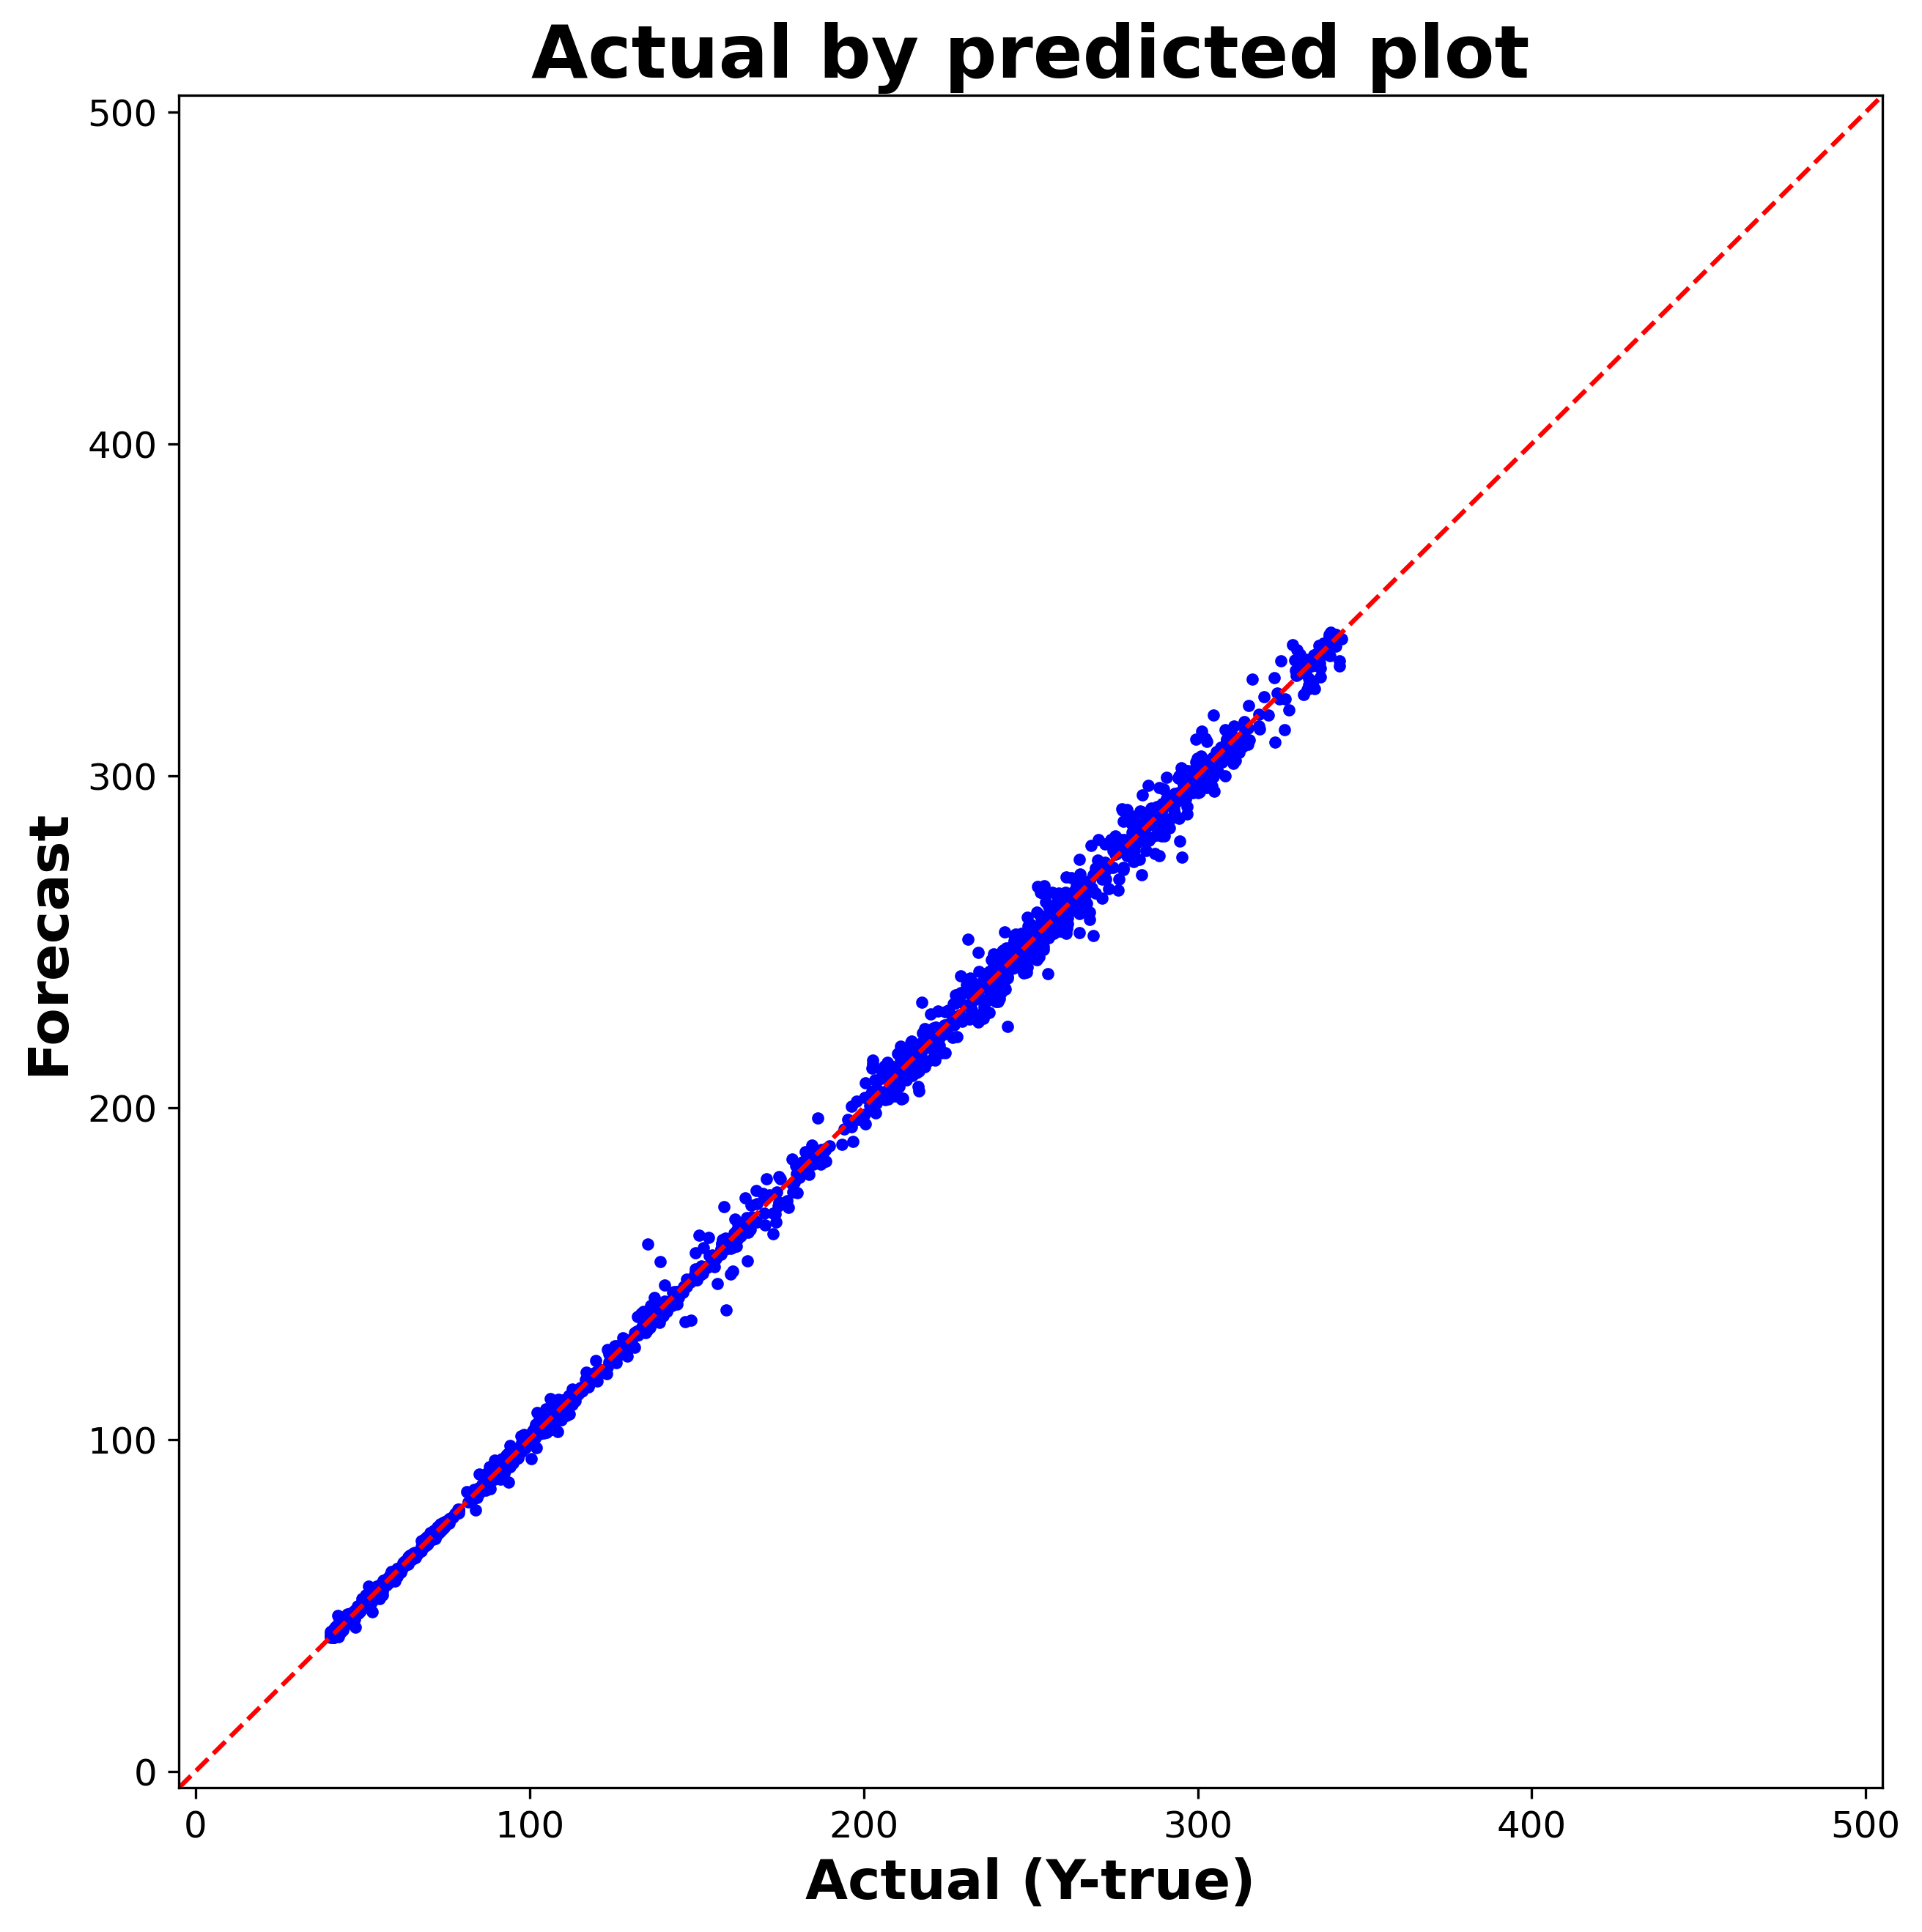

In [34]:

# Lock the scale of axis by Y_true
max_value=500+5
min_value=0-5

# Figure setting
plt.figure(figsize=(10,10),dpi=300)
plt.title('Actual by predicted plot',weight='bold',fontsize=24)
plt.xlabel('Actual (Y-true)',fontsize=18,weight='bold')
plt.ylabel('Forecast',fontsize=18,weight='bold')

# Perfect model reference line
plt.plot([min_value,max_value], [min_value,max_value], linestyle='--',color='red')

# Actual by predicted plot
plt.scatter(clean_df.iloc[:,1],clean_df.iloc[:,2],marker='.',color='blue')

# Set the axis
plt.ylim(0-5,max_value)
plt.xlim(0-5,max_value)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()